In [68]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

import sys
sys.path.insert(0, "../scripts")
import helpers as h

## Pull Data

In [94]:
file_types = {
            "temp": f"NatSciData_E{room_num}Tair.csv",
            "bw": f"NatSciData_E{room_num}W.csv", # bottom window 
            "tw": f"NatSciData_E{room_num}WT.csv", # top window
            "occ": f"NatSciData_E{room_num}Occ.csv"
        }


def pull_and_filter_data(type, room_num="01", month="06", num_days=4, all_data=False, file_types=file_types):
    path = f"../../data/ext_data/schweiker 2019/{file_types[type]}"
    # print(path)
    df =  pd.read_csv(path)

    # convert datetime column to correct format 
    df.loc[:, "DateTime"] = pd.to_datetime(df["DateTime"])

    start = pd.to_datetime(f"2005-{month}-01 08:00")
    end = pd.to_datetime(f"2005-{month}-{1+num_days} 08:00")
    mask = (df['DateTime'] >= start) & (df['DateTime'] <= end)
    df_lim = df.loc[mask].reset_index(drop=True)

    if all_data: 
        return df
    else:
        return df_lim 
    

    

In [76]:
def pull_all_data_types(room_num="01", month="06", num_days=4, all_data=False):
    d = {}
    for type in file_types.keys():
            d[type] = pull_and_filter_data(type, room_num, month, num_days, all_data)
    return d

In [92]:
def plot_all_data_types(d):
    fig = go.Figure()

    # plot temp 
    fig.add_trace(go.Scatter(
    x=d["temp"]["DateTime"],
    y=h.normalize(d["temp"].iloc[:,1]), 
    mode='markers+lines',
    name="air temp"))

    ft_keys =  list(file_types.keys())
    ft_keys.remove("temp")

    for type in ft_keys:
        fig.add_trace(go.Scatter(
            x=d[type]["DateTime"],
            y=d[type].iloc[:,1], 
            mode='markers',
            name=type
            ))

    return fig



## Compare Data

In [95]:
e01_sep10 = pull_all_data_types(room_num="01", month="09", num_days=10)
plot_all_data_types(e01_sep10)

In [98]:
e01_june5 = pull_all_data_types(room_num="01", month="06", num_days=5)
plot_all_data_types(e01_june5)

## Distributions of Occupant Data

In [ ]:
e01_bw, _ = pull_and_filter_data("bw",)
e01_tw, _ = pull_and_filter_data("tw")
e01_occ, _ = pull_and_filter_data("occ")
e01_temp, _ = pull_and_filter_data("temp")

<AxesSubplot:xlabel='DateTime,DateTime'>

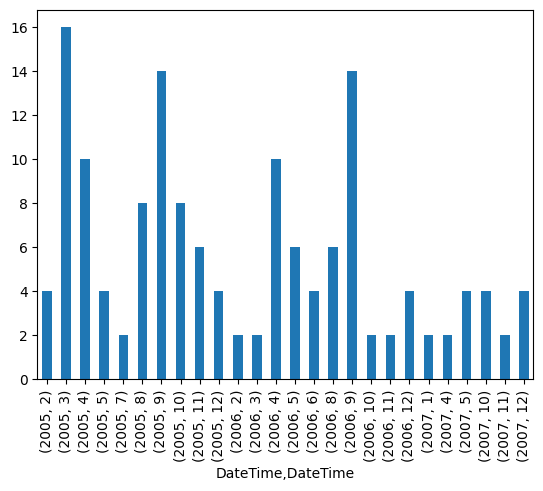

In [55]:
e01_bw["DateTime"].groupby([e01_bw["DateTime"].dt.year, e01_bw["DateTime"].dt.month]).count().plot(kind="bar")

<AxesSubplot:xlabel='DateTime,DateTime'>

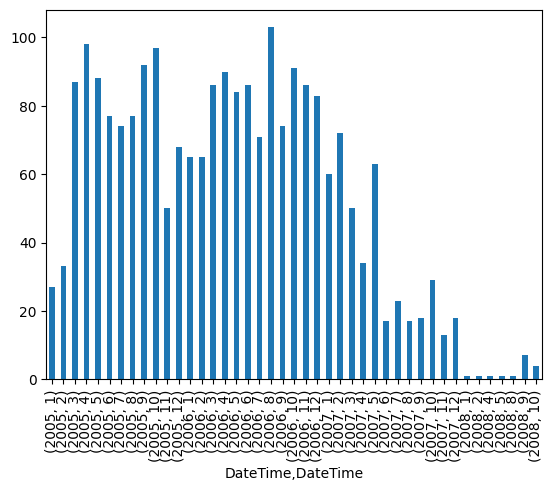

In [58]:
e01_tw["DateTime"].groupby([e01_tw["DateTime"].dt.year, e01_tw["DateTime"].dt.month]).count().plot(kind="bar")

<AxesSubplot:xlabel='DateTime,DateTime'>

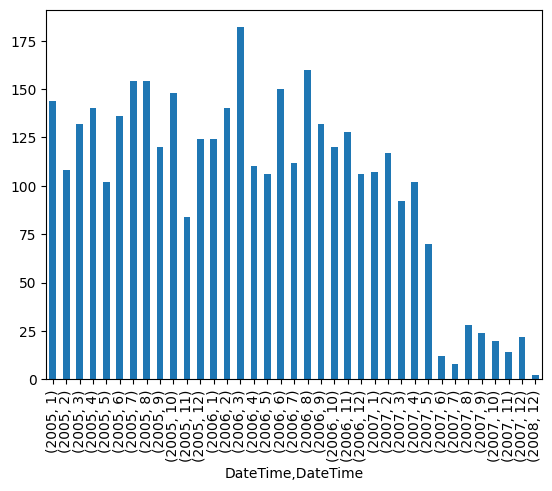

In [54]:
occ_hist = e01_occ["DateTime"].groupby([e01_occ["DateTime"].dt.year, e01_occ["DateTime"].dt.month]).count().plot(kind="bar")